In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, "..")
from src import config, preprocessing, recommender, plots, arxiv_utils

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

## Import and cleaning

In [3]:
# We start by importing the data
all_df = pd.read_csv(config.path_data_merged)
all_df.info()
all_df["published"] = pd.to_datetime(all_df["published"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5023 entries, 0 to 5022
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     5023 non-null   object
 1   title                  5023 non-null   object
 2   authors                5023 non-null   object
 3   primary_category       5023 non-null   object
 4   categories             5023 non-null   object
 5   summary                5023 non-null   object
 6   published              5023 non-null   object
 7   doi                    5023 non-null   object
 8   is_cited_by_my_papers  5023 non-null   bool  
 9   is_in_library          5023 non-null   bool  
dtypes: bool(2), object(8)
memory usage: 323.9+ KB


This dataset has only a few columns, some of which are text-based and will need to be properly encoded. The `published` column simply gives an idea of how recent the research is, while the `is_cited_by_my_papers` accounts for papers which I have cited in my own work and the column `is_in_library` accounts for the papers inside my Zotero library.

## Statistical analysis

First we see the dataset is skewed since we sampled a lot more of papers randomly than there are in the library.

<Axes: xlabel='is_in_library', ylabel='Count'>

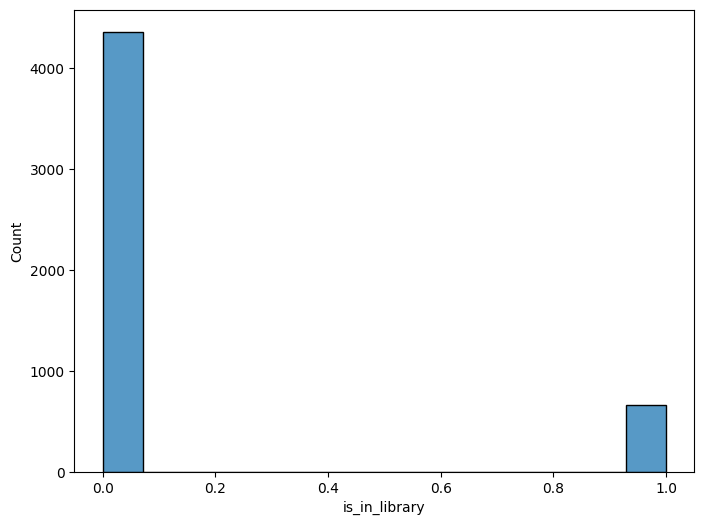

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(all_df, x="is_in_library")

The first thing we see is that as expected, the distribution of years for articles is skewed when considering those of interest. Since most research work is first based on recent results, it makes sense that the most relevant papers in a to-read list are recent as well. On the other hand, the papers which are not of interest are more spread out. Some of the small maxima can be attributed to the rough sample size (which is not large enough to fully smooth it out) and to the intrisic dependence on how many papers are published each year in each category.

The second thing we see is that by construction, all papers which are not of interest were also not part of the papers I cited. This is a pretty clear consequence.

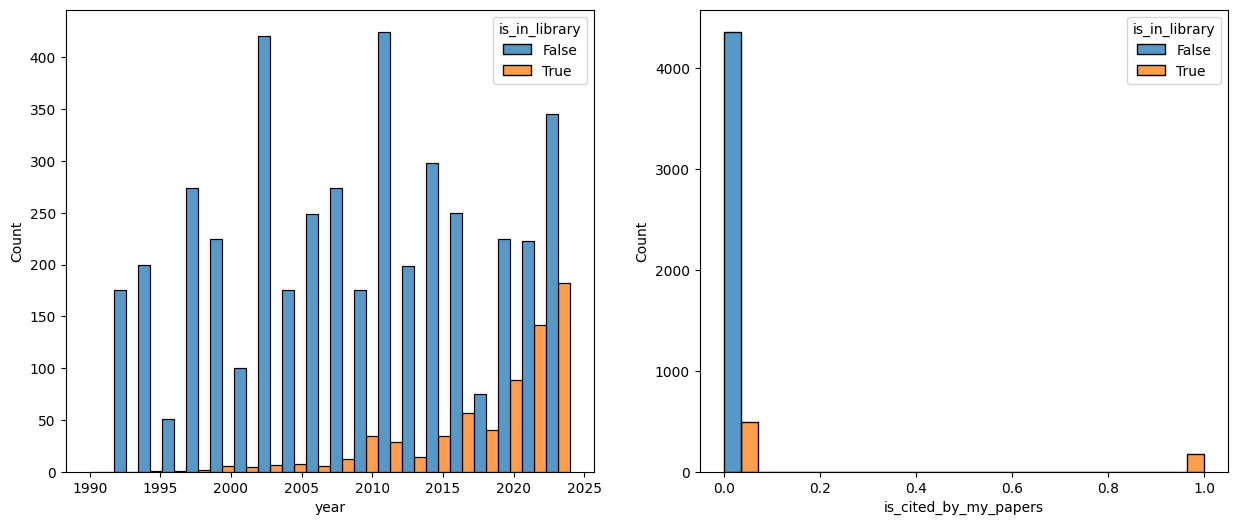

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
all_df["year"] = all_df["published"].dt.year
sns.histplot(data=all_df, x="year", multiple="dodge", hue="is_in_library", binrange=(1990, 2024), ax=axs[0])
sns.histplot(data=all_df, x="is_cited_by_my_papers", multiple="dodge", hue="is_in_library", ax=axs[1])
fig.savefig(config.path_figs / "distribution_papers_library.png", dpi=300)

## Encoding

The cleaning process acts differently for titles and authors depending on how they'll be encoded:
- For titles, we are looking for keywords so we will use a CountVectorizer encoding which removes english stop words. The cleaning process there is therefore to remove punctuation and possible LaTeX characters.
- For the authors list, we will also use CountVectorizer but we will encode every author as a word, so spaces must delimitate different authors and we will use the underscore as a space within the name character.
- For categories, we will use CountVectorizer where each category is a word.
- For primary categories, we will use a LabelEncoder since there are a finite amount of categories.

In [8]:
all_df_clean = preprocessing.pipeline_arxiv_articles.fit_transform(all_df)
all_df_clean.head()

,id,title,authors,primary_category,categories,summary,published,doi,is_cited_by_my_papers,is_in_library,year,authors_split
0,2312.12349,Holographic complexity braneworld gravity vers...,Sergio_E._Aguilar-Gutierrez Ben_Craps Juan_Her...,hep-th,hep-th gr-qc,We explore the complexity equals volume propos...,2023-12-19 17:28:43+00:00,10.1007/JHEP03(2024)173,False,True,2023,"[Sergio_E._Aguilar-Gutierrez, Ben_Craps, Juan_..."
1,2311.04093,Krylov complexity is not a measure of distance...,Sergio_E._Aguilar-Gutierrez Andrew_Rolph,hep-th,hep-th quant-ph,We ask whether Krylov complexity is mutually c...,2023-11-07 16:04:10+00:00,10.48550/2311.04093,False,True,2023,"[Sergio_E._Aguilar-Gutierrez, Andrew_Rolph]"
2,2310.15868,Anomalous Strangeness Transport,Eugenio_Megias Miguel_A._Vazquez-Mozo,hep-th,hep-th hep-ph nucl-th,Nondissipative transport of strangeness is stu...,2023-10-24 14:24:14+00:00,10.1007/JHEP01(2024)174,False,True,2023,"[Eugenio_Megias, Miguel_A._Vazquez-Mozo]"
3,2312.03848,Quantum chaos integrability and late times in ...,Vijay_Balasubramanian Javier_M._Magan Qingyue_Wu,hep-th,hep-th cond-mat.stat-mech nlin.CD quant-ph,Quantum chaotic systems are conjectured to dis...,2023-12-06 19:02:22+00:00,10.48550/2312.03848,False,True,2023,"[Vijay_Balasubramanian, Javier_M._Magan, Qingy..."
4,2305.00037,Integrability and complexity in quantum spin c...,Ben_Craps Marine_De_Clerck Oleg_Evnin Philip_H...,quant-ph,quant-ph cond-mat.stat-mech hep-th math-ph mat...,There is a widespread perception that dynamica...,2023-04-28 18:22:06+00:00,10.21468/SciPostPhys.16.2.041,False,True,2023,"[Ben_Craps, Marine_De_Clerck, Oleg_Evnin, Phil..."


In [9]:
all_df_clean["authors"]

0       Sergio_E._Aguilar-Gutierrez Ben_Craps Juan_Her...
1                Sergio_E._Aguilar-Gutierrez Andrew_Rolph
2                   Eugenio_Megias Miguel_A._Vazquez-Mozo
3        Vijay_Balasubramanian Javier_M._Magan Qingyue_Wu
4       Ben_Craps Marine_De_Clerck Oleg_Evnin Philip_H...
                              ...                        
5018    A._S._Cavichini M._T._Orlando J._B._Depianti J...
5019                            Jace_Cruddas B._J._Powell
5020                                             M._Iskin
5021    Alexandru_Macridin Panagiotis_Spentzouris Jame...
5022      Fahad_Mahmood Xi_He Ivan_Bozovic N._P._Armitage
Name: authors, Length: 5023, dtype: object

### Keywords

Let us see what are the most important keywords from this encoding. 
- For titles, we will be using unigram and bigram encoding with max features of 10000.
- For authors, we will only use unigram and bigram encoding with max features of 10000.
- For categories we will use unigram and bigram encoding and due to the small vocabulary, we will not need a number of max features.

English words will be stemmed in order to improve accuracy.

In [10]:
def get_vocab_list(cv, cvFit):
    """Returns a pandas Series containing each token from a CountVectorizer fit and the number of occurences.

    Args:
        cv: A CountVectorizer fitted instance.
        cvFit: Sparse matrix output from the fit_transform method of the CountVectorizer instance.

    Returns:
        pandas.Series: A series indexed by the tokens with values the number of occurences
    """
    word_list = cv.get_feature_names_out()
    count_list = np.asarray(cvFit.sum(axis=0))[0]

    vocab = pd.Series(dict(zip(word_list, count_list)))
    vocab = vocab.sort_values(ascending=False)
    return vocab

In [11]:
cvTitle = preprocessing.get_cv(ngram_range=(1, 2), max_features=10_000, stemming=True)
cvTitleNoStem = preprocessing.get_cv(ngram_range=(1, 2), max_features=10_000, stemming=False)
cvAuthors = preprocessing.get_cv(ngram_range=(1, 2), max_features=10_000)
cvCategories = preprocessing.get_cv(ngram_range=(1, 2))

cvTitleFit = cvTitle.fit_transform(all_df_clean["title"])
vocabTitle = get_vocab_list(cvTitle, cvTitleFit)

cvTitleNoStemFit = cvTitleNoStem.fit_transform(all_df_clean["title"])
vocabTitleNoStem = get_vocab_list(cvTitleNoStem, cvTitleNoStemFit)

cvAuthorsFit = cvAuthors.fit_transform(all_df_clean["authors"])
vocabAuthors = get_vocab_list(cvAuthors, cvAuthorsFit)

cvCategoriesFit = cvCategories.fit_transform(all_df_clean["categories"])
vocabCategories = get_vocab_list(cvCategories, cvCategoriesFit)

cvTitleFitLibrary = cvTitle.fit_transform(all_df_clean.loc[all_df_clean["is_in_library"], "title"])
vocabTitleLibrary = get_vocab_list(cvTitle, cvTitleFitLibrary)

cvTitleNoStemFitLibrary = cvTitleNoStem.fit_transform(all_df_clean.loc[all_df_clean["is_in_library"], "title"])
vocabTitleNoStemLibrary = get_vocab_list(cvTitleNoStem, cvTitleNoStemFitLibrary)

cvAuthorsFitLibrary = cvAuthors.fit_transform(all_df_clean.loc[all_df_clean["is_in_library"], "authors"])
vocabAuthorsLibrary = get_vocab_list(cvAuthors, cvAuthorsFitLibrary)

cvCategoriesFitLibrary = cvCategories.fit_transform(all_df_clean.loc[all_df_clean["is_in_library"], "categories"])
vocabCategoriesLibrary = get_vocab_list(cvCategories, cvCategoriesFitLibrary)

cvTitleFitNotLibrary = cvTitle.fit_transform(all_df_clean.loc[-all_df_clean["is_in_library"], "title"])
vocabTitleNotLibrary = get_vocab_list(cvTitle, cvTitleFitNotLibrary)

cvTitleNoStemFitNotLibrary = cvTitleNoStem.fit_transform(all_df_clean.loc[-all_df_clean["is_in_library"], "title"])
vocabTitleNoStemNotLibrary = get_vocab_list(cvTitleNoStem, cvTitleNoStemFitNotLibrary)

cvAuthorsFitNotLibrary = cvAuthors.fit_transform(all_df_clean.loc[-all_df_clean["is_in_library"], "authors"])
vocabAuthorsNotLibrary = get_vocab_list(cvAuthors, cvAuthorsFitNotLibrary)

cvCategoriesFitNotLibrary = cvCategories.fit_transform(all_df_clean.loc[-all_df_clean["is_in_library"], "categories"])
vocabCategoriesNotLibrary = get_vocab_list(cvCategories, cvCategoriesFitNotLibrary)

We can look at the top 10 words and authors in this dataset and compare to those of the reduced dataset for papers of interest.

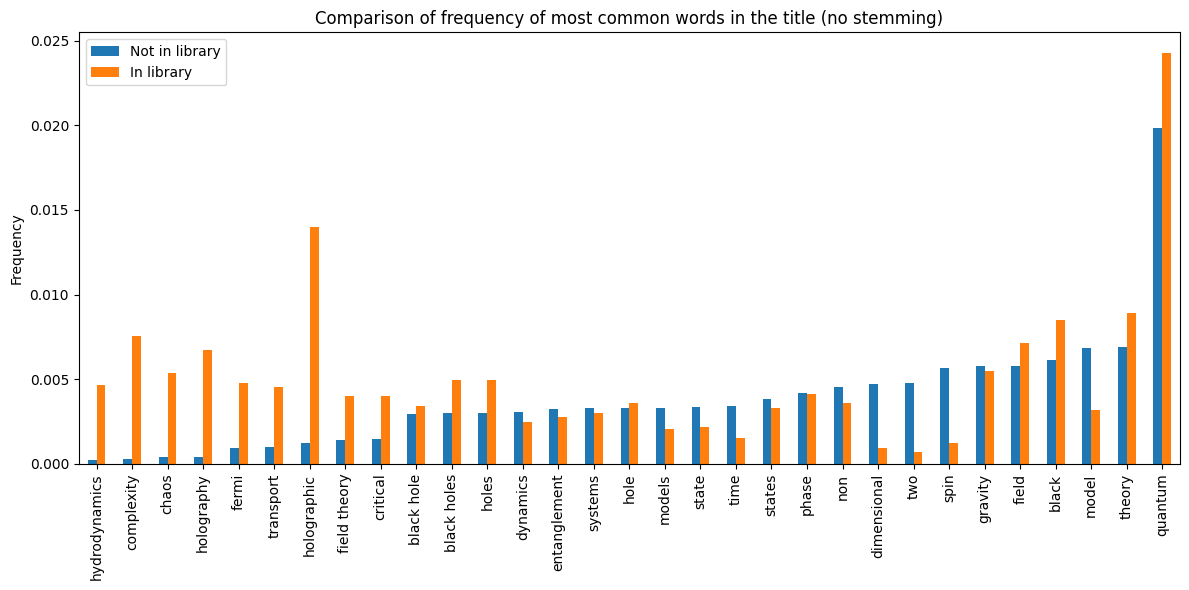

In [12]:
ntop = 10
fig, ax = plt.subplots(figsize=(12, 6))
plots.plot_top_n(
    vocabTitleNoStemNotLibrary, vocabTitleNoStemLibrary, cols=["Not in library", "In library"], ax=ax, ntop=20
)
ax.set_title("Comparison of frequency of most common words in the title (no stemming)")
ax.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(config.path_figs / "frequency_title_words_bigram_no_stemming.png", dpi=300)

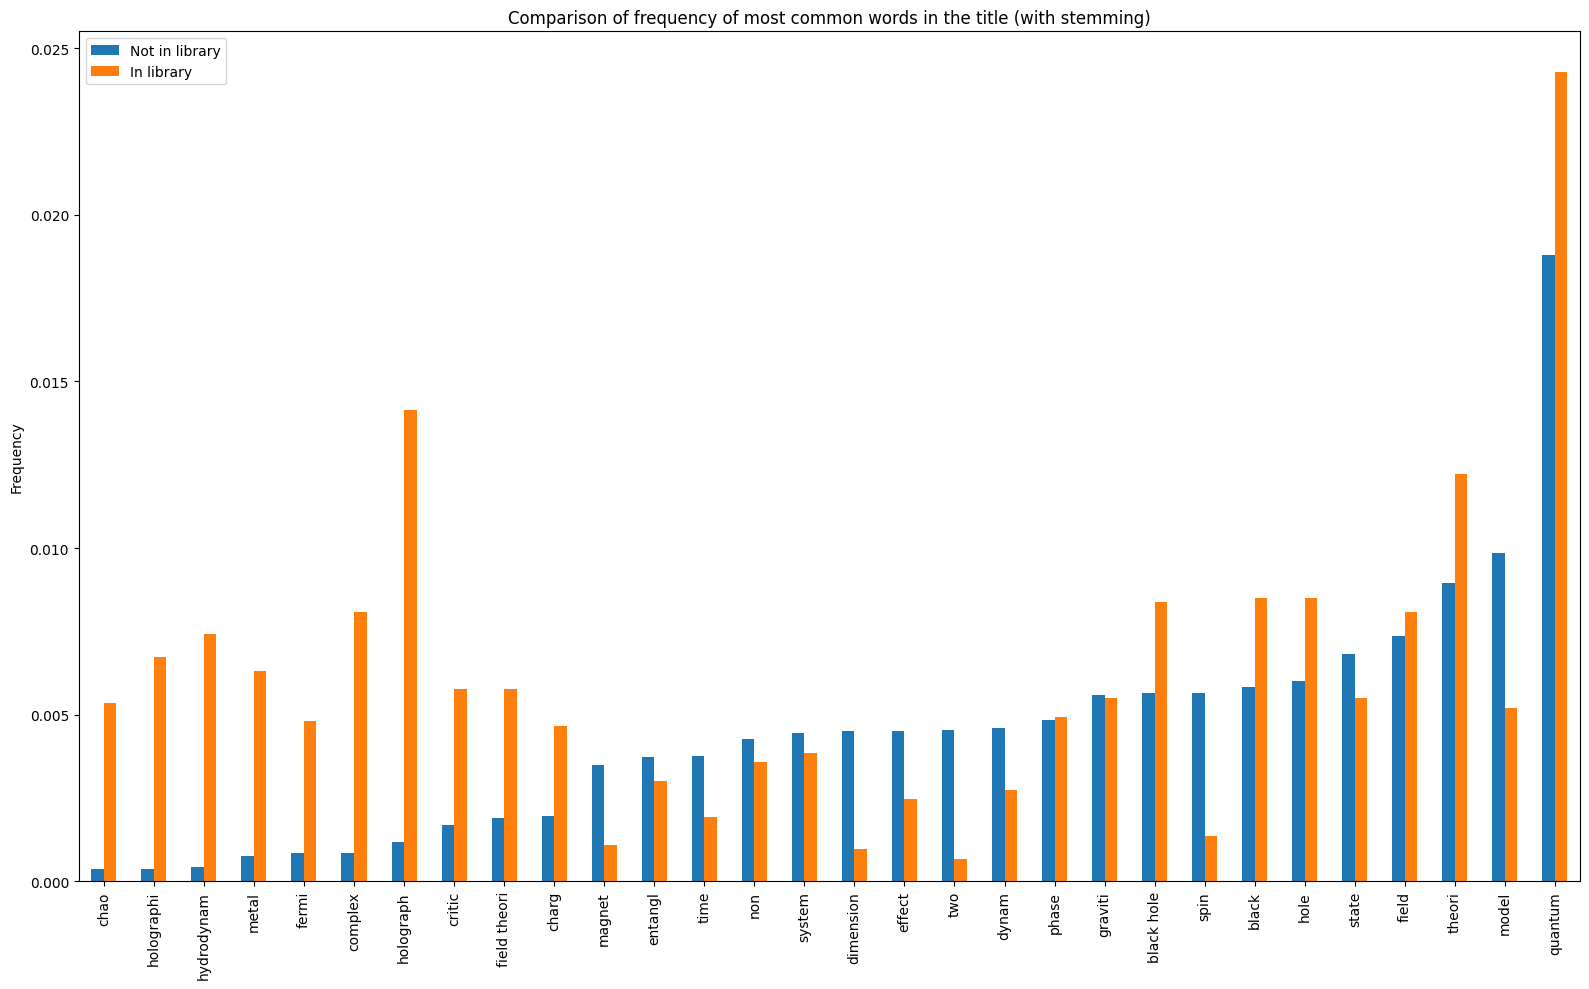

In [13]:
ntop = 10
fig, ax = plt.subplots(figsize=(16, 10))
plots.plot_top_n(vocabTitleNotLibrary, vocabTitleLibrary, cols=["Not in library", "In library"], ax=ax, ntop=20)
ax.set_title("Comparison of frequency of most common words in the title (with stemming)")
ax.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(config.path_figs / "frequency_title_words_bigram.png", dpi=300)

We see that stemming is a great way to identify words or groups of words whose exact spelling can vary (`black hole`, `black holes`).

The distribution of top keywords in the title changes in the "library" part of the dataset, with a stronger emphasis towards my domain of interest `quantum`, `holography`, `holographic`, `complexity` and `gravity`.

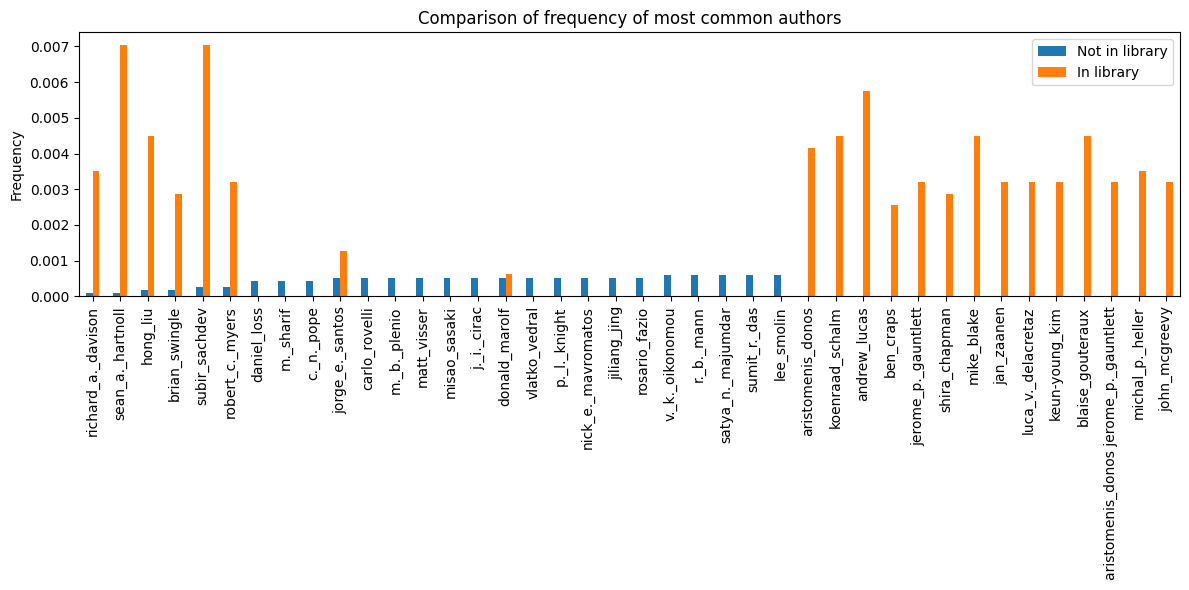

In [14]:
ntop = 10
fig, ax = plt.subplots(figsize=(12, 6))
plots.plot_top_n(vocabAuthorsNotLibrary, vocabAuthorsLibrary, cols=["Not in library", "In library"], ax=ax, ntop=20)
ax.set_title("Comparison of frequency of most common authors")
ax.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(config.path_figs / "frequency_authors_words_bigram.png", dpi=300)

The distribution of top authors is very different however in two ways: they are almost disjoint and the average frequency in library seems much higher than the random sample.

This can be understood from the very large amount of unique authors in the arXiv: this means the odds of a specific author in library being sampled is very slim, and similarly for the odds of a repeated sampling. This can be confirmed by looking at the distribution of frequencies in both vocabularies.

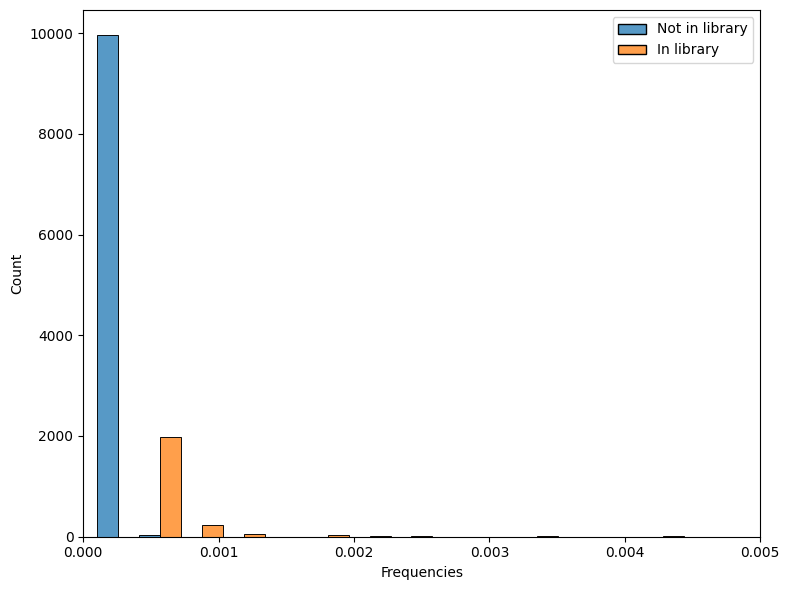

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(
    {
        "Not in library": vocabAuthorsNotLibrary.values / len(vocabAuthorsNotLibrary.values),
        "In library": vocabAuthorsLibrary.values / len(vocabAuthorsLibrary.values),
    },
    ax=ax,
    multiple="dodge",
    bins=30,
)
ax.set_xlim((0, 0.005))
ax.set_xlabel("Frequencies")
fig.tight_layout()
fig.savefig(config.path_figs / "frequency_categories_words_bigram.png", dpi=300)

Interestingly, the frequencies of categories are similar in both datasets. However, when thinking about it, it makes sense.
1. An article can be in multiple categories simultaneously,
2. Some categories are much larger and popular than others, especially considering the "division" of categories in cond-mat for example.

When considering those two points, it stands to reason that by probing many articles, we are simply probing the relative size of each categories.

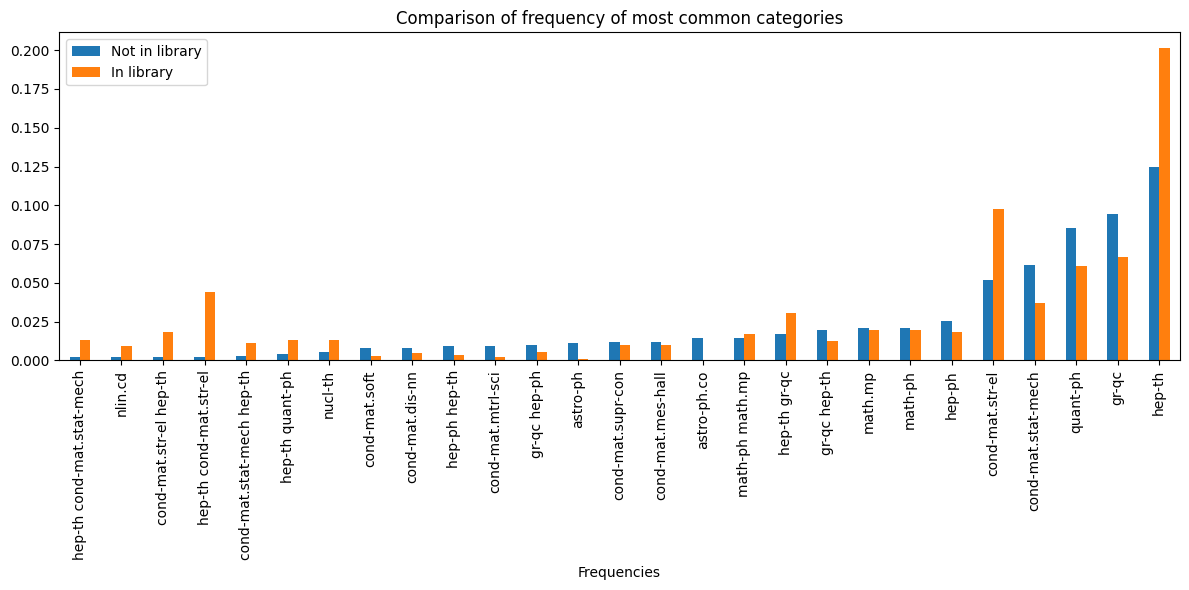

In [16]:
ntop = 10
fig, ax = plt.subplots(figsize=(12, 6))
plots.plot_top_n(
    vocabCategoriesNotLibrary, vocabCategoriesLibrary, cols=["Not in library", "In library"], ax=ax, ntop=20
)
ax.set_title("Comparison of frequency of most common categories")
ax.set_xlabel("Frequencies")
fig.tight_layout()
fig.savefig(config.path_figs / "distribution_categories_library.png", dpi=300)

This can be further understood by looking at the distribution of primary categories which are more "unique" (an article must choose only one). As expected, the distribution is very similar.

<Axes: xlabel='primary_category'>

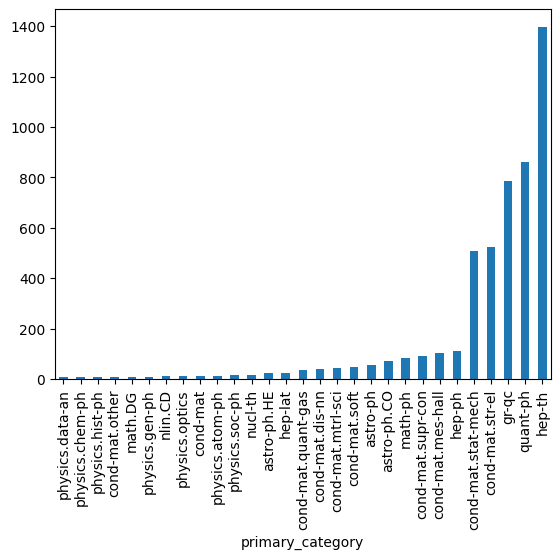

In [15]:
all_df_primary = all_df.groupby("primary_category").count()["id"]
all_df_primary.loc[all_df_primary > 5].sort_values().plot(kind="bar")

## Unsupervised classification

### PCA

Usually, PCA can account for a significant portion of the variance in a couple of dimensions. Here even with 10, barely 6% is accounted for. We see that on average, a dimension returned by PCA accounts less than 1% of the variance hence there is no benefit to considering this decomposition.

In [16]:
# We use the word soup column for this since it accounts for both authors and titles
all_df_clean_ws = preprocessing.BuildWordSoup(["title", "authors"]).fit_transform(all_df_clean)
all_df_encoded = preprocessing.get_cv(ngram_range=(1, 2), max_features=1_000_000).fit_transform(
    all_df_clean_ws["word_soup_title_authors"]
)

n_components = 10
pca = PCA(n_components=n_components, svd_solver="arpack")
output_pca = pca.fit_transform(all_df_encoded)
print(
    f"Using PCA with {n_components} components, only {100*pca.explained_variance_ratio_.sum()}% of the variance is explained!"
)
print(f"The average variance portion per dimension is {np.mean(100*pca.explained_variance_ratio_)}%")

Using PCA with 10 components, only 6.449386064948154% of the variance is explained!
The average variance portion per dimension is 0.6449386064948154%


## Recommendation system

To make a recommendation system, we just need to vectorize the entries titles and authors. Then by computing the cosine similarity between vectors, it is possible to find the most similar entries w.r.t. that metric.

We will now compare the results of multiple methods:
1. encoding only titles (this will ignore authors entirely),
2. encoding only authors (this will ignore titles entirely),
3. encoding both titles and authors in a single word soup,
4. weighing the scores of points 1. and 2. in order to establish an overall matching score.

The first two methods will likely be the ones with most flaws: by ignoring either fields, crucial correlations between authors and topics will be missing. The second method will also likely have a strong bias for an entries author similar works which could be an interesting "more by these authors" feature.

Method 4. is similar to method 3. in spirit, but the average is manual instead of geometric and so will produce qualitatively similar but quantitatively different results.

In [17]:
from itertools import product

# build all word soups
cols_to_soup = ["title", "authors", "categories"]
for col1, col2 in product(cols_to_soup, cols_to_soup):
    all_df_clean = preprocessing.BuildWordSoup([col1, col2]).fit_transform(all_df_clean)
all_df_clean = preprocessing.BuildWordSoup(cols_to_soup).fit_transform(all_df_clean)

# Build cosine similarity matrices
cos_mat_title, _ = recommender.build_similarity_matrix(
    all_df_clean["title"], preprocessing.get_cv(ngram_range=(1, 2), max_features=10_000, stemming=True)
)
cos_mat_authors, _ = recommender.build_similarity_matrix(
    all_df_clean["authors"], preprocessing.get_cv(ngram_range=(1, 2), max_features=10_000)
)
cos_mat_word_soup_title_authors, _ = recommender.build_similarity_matrix(
    all_df_clean["word_soup_title_authors"], preprocessing.get_cv(ngram_range=(1, 2), max_features=10_000)
)

In [18]:
# List of my papers
my_papers = [574, 33, 580]

In [19]:
all_df.loc[my_papers, ["id", "title", "authors", "categories", "summary"]]

,id,title,authors,categories,summary
574,2211.05492,"T-linear resistivity, optical conductivity and...",Floris Balm ; Nicolas Chagnet ; Sam Arend ; Jo...,cond-mat.str-el hep-th,High $T_c$ cuprate strange metals are noted fo...
33,2303.17685,Hydrodynamics of a relativistic charged fluid ...,Nicolas Chagnet ; Koenraad Schalm,cond-mat.str-el cond-mat.soft cond-mat.supr-co...,We study charged hydrodynamics in a periodic l...
580,2209.13951,Quantization and variational problem of the Gu...,Nicolas Chagnet ; Floris Balm ; Koenraad Schalm,hep-th,We show that the strongly coupled field theory...


Now we can compare each method using the first paper, with identifier 33 which is

In [28]:
print(f"The title is {all_df.iloc[my_papers[0]]['title']}")
print(f"The authors are {all_df.iloc[my_papers[0]]['authors']}")

The title is T-linear resistivity, optical conductivity and Planckian transport for a holographic local quantum critical metal in a periodic potential
The authors are Floris Balm ; Nicolas Chagnet ; Sam Arend ; Joost Aretz ; Kevin Grosvenor ; Martijn Janse ; Ole Moors ; Jonah Post ; Vladimir Ohanesjan ; David Rodriguez-Fernandez ; Koenraad Schalm ; Jan Zaanen


We can see from the result below that as expected, the authors-based method mostly looks for papers with the authors in common. Interestingly, my third paper which has all the same authors only comes up 5th, because that paper has many *more* authors and is therefore further as a vector. Many of these have nothing to do with hydrodynamics per se unlike the base paper.

The title-based methods on the other hand shows very different papers, all of which have something to do with criticality, conductivity, etc...

In [25]:
recommendation_authors = recommender.get_similar_entries_entry(all_df, my_papers[0], [cos_mat_authors]).drop(
    ["paper_id", "paper_authors", "paper_title"], axis=1
)
recommendation_titles = recommender.get_similar_entries_entry(all_df, my_papers[0], [cos_mat_title]).drop(
    ["paper_id", "paper_authors", "paper_title"], axis=1
)
display(recommendation_authors)
display(recommendation_titles)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Quantization and variational problem of the Gu...,Nicolas Chagnet ; Floris Balm ; Koenraad Schalm,hep-th,2209.13951,0.400892
1,Anomalous attenuation of plasmons in strange m...,Aurelio Romero-Bermúdez ; Alexander Krikun ; K...,cond-mat.str-el hep-th,1812.03968,0.358569
2,Holographic duality and the resistivity of str...,Richard A. Davison ; Koenraad Schalm ; Jan Zaanen,hep-th cond-mat.str-el,1311.2451,0.358569
3,Hydrodynamics of a relativistic charged fluid ...,Nicolas Chagnet ; Koenraad Schalm,cond-mat.str-el cond-mat.soft cond-mat.supr-co...,2303.17685,0.308607
4,Quantum corrected phase diagram of holographic...,Mariya V. Medvedyeva ; Elena Gubankova ; Mihai...,hep-th cond-mat.str-el,1302.5149,0.303046
5,"Planckian dissipation, minimal viscosity and t...",Jan Zaanen,cond-mat.str-el hep-th,1807.10951,0.267261
6,Lectures on quantum supreme matter,Jan Zaanen,cond-mat.str-el cond-mat.stat-mech cond-mat.su...,2110.00961,0.267261
7,"String Theory, Quantum Phase Transitions and t...",Mihailo Cubrovic ; Jan Zaanen ; Koenraad Schalm,hep-th cond-mat.str-el,0904.1993,0.239046
8,Constructing the AdS dual of a Fermi liquid: A...,Mihailo Čubrović ; Jan Zaanen ; Koenraad Schalm,hep-th cond-mat.str-el,1012.5681,0.239046
9,Spectral probes of the holographic Fermi groun...,Mihailo Cubrovic ; Yan Liu ; Koenraad Schalm ;...,hep-th cond-mat.str-el cond-mat.supr-con,1106.1798,0.188982


,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Incoherent transport in clean quantum critical...,Richard A. Davison ; Blaise Goutéraux ; Sean A...,hep-th cond-mat.str-el,1507.07137,0.436436
1,Optical Conductivity with Holographic Lattices,Gary T. Horowitz ; Jorge E. Santos ; David Tong,hep-th cond-mat.str-el,1204.0519,0.356348
2,Quantum Criticality and Holographic Supercondu...,Jerome Gauntlett ; Julian Sonner ; Toby Wiseman,hep-th,0912.0512,0.329914
3,Optical conductivity of the Frohlich polaron,A. S. Mishchenko ; N. Nagaosa ; N. V. Prokof'e...,cond-mat.str-el cond-mat.stat-mech,cond-mat/0312111,0.327327
4,Reconciling scaling of the optical conductivit...,B. Michon ; C. Berthod ; C. W. Rischau ; A. At...,cond-mat.str-el cond-mat.supr-con,2205.04030,0.302614
5,Quantum critical scaling of the conductivity t...,D. Hazra ; Prosenjit Haldar ; M. S. Laad ; N. ...,cond-mat.str-el cond-mat.dis-nn cond-mat.supr-con,1906.11209,0.291606
6,Thermal conductivity at a disordered quantum c...,Sean A. Hartnoll ; David M. Ramirez ; Jorge E....,hep-th cond-mat.str-el gr-qc,1508.04435,0.276026
7,Slow relaxation and diffusion in holographic q...,Richard A. Davison ; Simon A. Gentle ; Blaise ...,hep-th cond-mat.str-el,1808.05659,0.276026
8,Generalized Holographic Quantum Criticality at...,B. Goutéraux ; E. Kiritsis,hep-th cond-mat.str-el gr-qc,1107.2116,0.276026
9,Quantum critical scaling and holographic bound...,Gian Andrea Inkof ; Joachim M. C. Kuppers ; J...,cond-mat.str-el hep-th quant-ph,1907.05744,0.272772


In [30]:
print(f"The title is {all_df.iloc[my_papers[1]]['title']}")
print(f"The authors are {all_df.iloc[my_papers[1]]['authors']}")

The title is Hydrodynamics of a relativistic charged fluid in the presence of a periodically modulated chemical potential
The authors are Nicolas Chagnet ; Koenraad Schalm


In [29]:
recommendation_authors = recommender.get_similar_entries_entry(all_df, my_papers[1], [cos_mat_authors]).drop(
    ["paper_id", "paper_authors", "paper_title"], axis=1
)
recommendation_titles = recommender.get_similar_entries_entry(all_df, my_papers[1], [cos_mat_title]).drop(
    ["paper_id", "paper_authors", "paper_title"], axis=1
)
display(recommendation_authors)
display(recommendation_titles)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Quantization and variational problem of the Gu...,Nicolas Chagnet ; Floris Balm ; Koenraad Schalm,hep-th,2209.13951,0.577350
1,Black hole scrambling from hydrodynamics,Sašo Grozdanov ; Koenraad Schalm ; Vincenzo Sc...,hep-th cond-mat.str-el gr-qc nlin.CD,1710.00921,0.333333
2,Decoupling in an expanding universe: boundary ...,Koenraad Schalm ; Gary Shiu ; Jan Pieter van d...,hep-th astro-ph gr-qc,hep-th/0401164,0.333333
3,"T-linear resistivity, optical conductivity and...",Floris Balm ; Nicolas Chagnet ; Sam Arend ; Jo...,cond-mat.str-el hep-th,2211.05492,0.308607
4,Hydrodynamic charge and heat transport on inho...,Vincenzo Scopelliti ; Koenraad Schalm ; Andrew...,cond-mat.str-el hep-th,1705.04325,0.288675
5,Scale-invariant hyperscaling-violating hologra...,Andrew Lucas ; Subir Sachdev ; Koenraad Schalm,hep-th cond-mat.str-el,1401.7993,0.288675
6,Holographic duality and the resistivity of str...,Richard A. Davison ; Koenraad Schalm ; Jan Zaanen,hep-th cond-mat.str-el,1311.2451,0.258199
7,S-Wave Superconductivity in Anisotropic Hologr...,Johanna Erdmenger ; Benedikt Herwerth ; Steffe...,hep-th cond-mat.str-el cond-mat.supr-con,1501.07615,0.258199
8,"String Theory, Quantum Phase Transitions and t...",Mihailo Cubrovic ; Jan Zaanen ; Koenraad Schalm,hep-th cond-mat.str-el,0904.1993,0.258199
9,Far from equilibrium energy flow in quantum cr...,M. J. Bhaseen ; Benjamin Doyon ; Andrew Lucas ...,hep-th cond-mat.stat-mech cond-mat.str-el,1311.3655,0.258199


,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Hydrodynamics of ideal fracton fluids,Kevin T. Grosvenor ; Carlos Hoyos ; Francisco ...,cond-mat.str-el cond-mat.quant-gas cond-mat.st...,2105.01084,0.267261
1,The Hydrohedron: Bootstrapping Relativistic Hy...,Michal P. Heller ; Alexandre Serantes ; Michał...,hep-th cond-mat.stat-mech gr-qc math-ph math.M...,2305.07703,0.267261
2,Quasinormal modes in charged fluids at complex...,Aron Jansen ; Christiana Pantelidou,hep-th,2007.14418,0.267261
3,Exact high temperature expansion of the one-lo...,Bruno Klajn,hep-ph hep-lat hep-th,1311.2512,0.251976
4,Fluid-gravity correspondence and causal first-...,Luca Ciambelli ; Luis Lehner,hep-th gr-qc,2310.15427,0.241747
5,Two-dimensional hydrodynamic electron flow thr...,Aaron Hui ; Calvin Pozderac ; Brian Skinner,cond-mat.str-el cond-mat.mes-hall,2309.15917,0.241747
6,Hydrodynamics of dipole-conserving fluids,Aleksander Głódkowski ; Francisco Peña-Benítez...,cond-mat.str-el cond-mat.soft cond-mat.stat-me...,2212.06848,0.239046
7,On the Kohn-Sham equations with periodic backg...,E. Prodan ; P. Nordlander,cond-mat.mtrl-sci cond-mat.stat-mech,cond-mat/0303518,0.239046
8,Lectures on hydrodynamic fluctuations in relat...,Pavel Kovtun,hep-th,1205.5040,0.218218
9,Relativistic hydrodynamics with phase transition,F. Taghinavaz,hep-th hep-ph nucl-th,2309.14773,0.218218


Now we can look at the result from the word soup.

In [26]:
recommendation_word_soup_title_authors = recommender.get_similar_entries_entry(
    all_df, my_papers[0], [cos_mat_word_soup_title_authors]
).drop(["paper_id", "paper_authors", "paper_title"], axis=1)
display(recommendation_word_soup_title_authors)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Quantum corrected phase diagram of holographic...,Mariya V. Medvedyeva ; Elena Gubankova ; Mihai...,hep-th cond-mat.str-el,1302.5149,0.283069
1,Holographic duality and the resistivity of str...,Richard A. Davison ; Koenraad Schalm ; Jan Zaanen,hep-th cond-mat.str-el,1311.2451,0.271964
2,Quantum critical scaling of the conductivity t...,D. Hazra ; Prosenjit Haldar ; M. S. Laad ; N. ...,cond-mat.str-el cond-mat.dis-nn cond-mat.supr-con,1906.11209,0.253185
3,Quantum critical scaling and holographic bound...,Gian Andrea Inkof ; Joachim M. C. Kuppers ; J...,cond-mat.str-el hep-th quant-ph,1907.05744,0.245145
4,Optical conductivity of the Frohlich polaron,A. S. Mishchenko ; N. Nagaosa ; N. V. Prokof'e...,cond-mat.str-el cond-mat.stat-mech,cond-mat/0312111,0.240192
5,Optical Conductivity with Holographic Lattices,Gary T. Horowitz ; Jorge E. Santos ; David Tong,hep-th cond-mat.str-el,1204.0519,0.236525
6,Holographic View on Quantum Correlations and M...,Javier Molina-Vilaplana ; Pasquale Sodano,quant-ph cond-mat.stat-mech hep-th,1108.1277,0.231125
7,The Holographic Entropy Bound and Local Quantu...,Ulvi Yurtsever,gr-qc hep-th quant-ph,gr-qc/0303023,0.226455
8,Reconciling scaling of the optical conductivit...,B. Michon ; C. Berthod ; C. W. Rischau ; A. At...,cond-mat.str-el cond-mat.supr-con,2205.04030,0.224961
9,Optical Conductivity of Ferromagnetic Semicond...,E. H. Hwang ; A. J. Millis ; S. Das Sarma,cond-mat.mtrl-sci cond-mat.str-el,cond-mat/0202071,0.222375


We can see this method has more balance by comparing the positions of the papers in the combined method compared to the two previous methods. What we see is that the title-based method has a larger overlap with the combined method when compared to the author-based method, only the ordering itself is different. On the other hand, some of my own papers which were absent in the title-based method but were present in the authors-based method are also present.
**As expected, this method provides a nice balance between the two.**

In [27]:
def find_pos_entry(x, df):
    list_titles = list(df["sim_entries_title"])
    if x in list_titles:
        return list_titles.index(x)
    else:
        return np.nan


recommendation_word_soup_title_authors["only_title"] = recommendation_word_soup_title_authors.apply(
    lambda x: find_pos_entry(x["sim_entries_title"], recommendation_titles), axis=1
)
recommendation_word_soup_title_authors["only_authors"] = recommendation_word_soup_title_authors.apply(
    lambda x: find_pos_entry(x["sim_entries_title"], recommendation_authors), axis=1
)

display(recommendation_word_soup_title_authors)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores,only_title,only_authors
0,Quantum corrected phase diagram of holographic...,Mariya V. Medvedyeva ; Elena Gubankova ; Mihai...,hep-th cond-mat.str-el,1302.5149,0.283069,NaN,4.0
1,Holographic duality and the resistivity of str...,Richard A. Davison ; Koenraad Schalm ; Jan Zaanen,hep-th cond-mat.str-el,1311.2451,0.271964,NaN,2.0
2,Quantum critical scaling of the conductivity t...,D. Hazra ; Prosenjit Haldar ; M. S. Laad ; N. ...,cond-mat.str-el cond-mat.dis-nn cond-mat.supr-con,1906.11209,0.253185,5.0,NaN
3,Quantum critical scaling and holographic bound...,Gian Andrea Inkof ; Joachim M. C. Kuppers ; J...,cond-mat.str-el hep-th quant-ph,1907.05744,0.245145,9.0,NaN
4,Optical conductivity of the Frohlich polaron,A. S. Mishchenko ; N. Nagaosa ; N. V. Prokof'e...,cond-mat.str-el cond-mat.stat-mech,cond-mat/0312111,0.240192,3.0,NaN
5,Optical Conductivity with Holographic Lattices,Gary T. Horowitz ; Jorge E. Santos ; David Tong,hep-th cond-mat.str-el,1204.0519,0.236525,1.0,NaN
6,Holographic View on Quantum Correlations and M...,Javier Molina-Vilaplana ; Pasquale Sodano,quant-ph cond-mat.stat-mech hep-th,1108.1277,0.231125,NaN,NaN
7,The Holographic Entropy Bound and Local Quantu...,Ulvi Yurtsever,gr-qc hep-th quant-ph,gr-qc/0303023,0.226455,NaN,NaN
8,Reconciling scaling of the optical conductivit...,B. Michon ; C. Berthod ; C. W. Rischau ; A. At...,cond-mat.str-el cond-mat.supr-con,2205.04030,0.224961,4.0,NaN
9,Optical Conductivity of Ferromagnetic Semicond...,E. H. Hwang ; A. J. Millis ; S. Das Sarma,cond-mat.mtrl-sci cond-mat.str-el,cond-mat/0202071,0.222375,NaN,NaN


Ideally, we would like to weigh the authors-based column higher, in order for the same-authors paper to be recommended more highly than in the current system. We can try to work with the weighing scheme instead. With equal weights, we notice it is strongly influenced by the author selection.

In [28]:
display(
    recommender.get_similar_entries_entry(
        all_df, my_papers[0], [cos_mat_title, cos_mat_authors], weights=[0.6, 0.4]
    ).drop(["paper_id", "paper_authors", "paper_title"], axis=1)
)
display(recommendation_authors)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Holographic duality and the resistivity of str...,Richard A. Davison ; Koenraad Schalm ; Jan Zaanen,hep-th cond-mat.str-el,1311.2451,0.282300
1,Incoherent transport in clean quantum critical...,Richard A. Davison ; Blaise Goutéraux ; Sean A...,hep-th cond-mat.str-el,1507.07137,0.261861
2,"Planckian dissipation, minimal viscosity and t...",Jan Zaanen,cond-mat.str-el hep-th,1807.10951,0.220294
3,Optical Conductivity with Holographic Lattices,Gary T. Horowitz ; Jorge E. Santos ; David Tong,hep-th cond-mat.str-el,1204.0519,0.213809
4,Quantum corrected phase diagram of holographic...,Mariya V. Medvedyeva ; Elena Gubankova ; Mihai...,hep-th cond-mat.str-el,1302.5149,0.213800
5,Quantum Criticality and Holographic Supercondu...,Jerome Gauntlett ; Julian Sonner ; Toby Wiseman,hep-th,0912.0512,0.197949
6,Optical conductivity of the Frohlich polaron,A. S. Mishchenko ; N. Nagaosa ; N. V. Prokof'e...,cond-mat.str-el cond-mat.stat-mech,cond-mat/0312111,0.196396
7,Hydrodynamics of a relativistic charged fluid ...,Nicolas Chagnet ; Koenraad Schalm,cond-mat.str-el cond-mat.soft cond-mat.supr-co...,2303.17685,0.193428
8,Anomalous attenuation of plasmons in strange m...,Aurelio Romero-Bermúdez ; Alexander Krikun ; K...,cond-mat.str-el hep-th,1812.03968,0.187071
9,Reconciling scaling of the optical conductivit...,B. Michon ; C. Berthod ; C. W. Rischau ; A. At...,cond-mat.str-el cond-mat.supr-con,2205.04030,0.181568


,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Quantization and variational problem of the Gu...,Nicolas Chagnet ; Floris Balm ; Koenraad Schalm,hep-th,2209.13951,0.400892
1,Anomalous attenuation of plasmons in strange m...,Aurelio Romero-Bermúdez ; Alexander Krikun ; K...,cond-mat.str-el hep-th,1812.03968,0.358569
2,Holographic duality and the resistivity of str...,Richard A. Davison ; Koenraad Schalm ; Jan Zaanen,hep-th cond-mat.str-el,1311.2451,0.358569
3,Hydrodynamics of a relativistic charged fluid ...,Nicolas Chagnet ; Koenraad Schalm,cond-mat.str-el cond-mat.soft cond-mat.supr-co...,2303.17685,0.308607
4,Quantum corrected phase diagram of holographic...,Mariya V. Medvedyeva ; Elena Gubankova ; Mihai...,hep-th cond-mat.str-el,1302.5149,0.303046
5,"Planckian dissipation, minimal viscosity and t...",Jan Zaanen,cond-mat.str-el hep-th,1807.10951,0.267261
6,Lectures on quantum supreme matter,Jan Zaanen,cond-mat.str-el cond-mat.stat-mech cond-mat.su...,2110.00961,0.267261
7,"String Theory, Quantum Phase Transitions and t...",Mihailo Cubrovic ; Jan Zaanen ; Koenraad Schalm,hep-th cond-mat.str-el,0904.1993,0.239046
8,Constructing the AdS dual of a Fermi liquid: A...,Mihailo Čubrović ; Jan Zaanen ; Koenraad Schalm,hep-th cond-mat.str-el,1012.5681,0.239046
9,Spectral probes of the holographic Fermi groun...,Mihailo Cubrovic ; Yan Liu ; Koenraad Schalm ;...,hep-th cond-mat.str-el cond-mat.supr-con,1106.1798,0.188982


We can see how tweaking the weight allows us to tweak the proportion of importance in authors vs titles.

For the rest of the analysis, we will use the word soup method because it is easier to setup (the weighing requires fine tuning). We can now add categories to see how it would fare. We don't put a maximal amount of features since the total number of features is small.

In [29]:
cos_mat_word_soup_title_authors_cats, _ = recommender.build_similarity_matrix(
    all_df_clean["word_soup_title_authors_categories"], preprocessing.get_cv(ngram_range=(1, 2))
)

We can see that the results care much more about the similarity of the category.

In [30]:
recommendation_word_soup_title_authors_cats = recommender.get_similar_entries_entry(
    all_df, my_papers[0], [cos_mat_word_soup_title_authors_cats]
).drop(["paper_id", "paper_authors", "paper_title"], axis=1)
display(recommendation_word_soup_title_authors_cats)
display(recommendation_word_soup_title_authors)
display(recommendation_titles)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Holographic duality and the resistivity of str...,Richard A. Davison ; Koenraad Schalm ; Jan Zaanen,hep-th cond-mat.str-el,1311.2451,0.220589
1,"Planckian dissipation, minimal viscosity and t...",Jan Zaanen,cond-mat.str-el hep-th,1807.10951,0.209822
2,Anomalous attenuation of plasmons in strange m...,Aurelio Romero-Bermúdez ; Alexander Krikun ; K...,cond-mat.str-el hep-th,1812.03968,0.200492
3,Optical Conductivity with Holographic Lattices,Gary T. Horowitz ; Jorge E. Santos ; David Tong,hep-th cond-mat.str-el,1204.0519,0.199889
4,Quantum corrected phase diagram of holographic...,Mariya V. Medvedyeva ; Elena Gubankova ; Mihai...,hep-th cond-mat.str-el,1302.5149,0.192305
5,Quantum critical scaling and holographic bound...,Gian Andrea Inkof ; Joachim M. C. Kuppers ; J...,cond-mat.str-el hep-th quant-ph,1907.05744,0.185745
6,Incoherent transport in clean quantum critical...,Richard A. Davison ; Blaise Goutéraux ; Sean A...,hep-th cond-mat.str-el,1507.07137,0.179847
7,Holographic Butterfly Effect and Diffusion in ...,Yi Ling ; Zhuo-Yu Xian,hep-th cond-mat.str-el,1707.02843,0.179847
8,Disordered quantum critical fixed points from ...,Xiaoyang Huang ; Subir Sachdev ; Andrew Lucas,cond-mat.str-el hep-th,2306.03130,0.179847
9,Transport near the Ising-nematic quantum criti...,Sean A. Hartnoll ; Raghu Mahajan ; Matthias Pu...,cond-mat.str-el hep-th,1401.7012,0.172695


,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores,only_title,only_authors
0,Quantum corrected phase diagram of holographic...,Mariya V. Medvedyeva ; Elena Gubankova ; Mihai...,hep-th cond-mat.str-el,1302.5149,0.283069,NaN,4.0
1,Holographic duality and the resistivity of str...,Richard A. Davison ; Koenraad Schalm ; Jan Zaanen,hep-th cond-mat.str-el,1311.2451,0.271964,NaN,2.0
2,Quantum critical scaling of the conductivity t...,D. Hazra ; Prosenjit Haldar ; M. S. Laad ; N. ...,cond-mat.str-el cond-mat.dis-nn cond-mat.supr-con,1906.11209,0.253185,5.0,NaN
3,Quantum critical scaling and holographic bound...,Gian Andrea Inkof ; Joachim M. C. Kuppers ; J...,cond-mat.str-el hep-th quant-ph,1907.05744,0.245145,9.0,NaN
4,Optical conductivity of the Frohlich polaron,A. S. Mishchenko ; N. Nagaosa ; N. V. Prokof'e...,cond-mat.str-el cond-mat.stat-mech,cond-mat/0312111,0.240192,3.0,NaN
5,Optical Conductivity with Holographic Lattices,Gary T. Horowitz ; Jorge E. Santos ; David Tong,hep-th cond-mat.str-el,1204.0519,0.236525,1.0,NaN
6,Holographic View on Quantum Correlations and M...,Javier Molina-Vilaplana ; Pasquale Sodano,quant-ph cond-mat.stat-mech hep-th,1108.1277,0.231125,NaN,NaN
7,The Holographic Entropy Bound and Local Quantu...,Ulvi Yurtsever,gr-qc hep-th quant-ph,gr-qc/0303023,0.226455,NaN,NaN
8,Reconciling scaling of the optical conductivit...,B. Michon ; C. Berthod ; C. W. Rischau ; A. At...,cond-mat.str-el cond-mat.supr-con,2205.04030,0.224961,4.0,NaN
9,Optical Conductivity of Ferromagnetic Semicond...,E. H. Hwang ; A. J. Millis ; S. Das Sarma,cond-mat.mtrl-sci cond-mat.str-el,cond-mat/0202071,0.222375,NaN,NaN


,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Incoherent transport in clean quantum critical...,Richard A. Davison ; Blaise Goutéraux ; Sean A...,hep-th cond-mat.str-el,1507.07137,0.436436
1,Optical Conductivity with Holographic Lattices,Gary T. Horowitz ; Jorge E. Santos ; David Tong,hep-th cond-mat.str-el,1204.0519,0.356348
2,Quantum Criticality and Holographic Supercondu...,Jerome Gauntlett ; Julian Sonner ; Toby Wiseman,hep-th,0912.0512,0.329914
3,Optical conductivity of the Frohlich polaron,A. S. Mishchenko ; N. Nagaosa ; N. V. Prokof'e...,cond-mat.str-el cond-mat.stat-mech,cond-mat/0312111,0.327327
4,Reconciling scaling of the optical conductivit...,B. Michon ; C. Berthod ; C. W. Rischau ; A. At...,cond-mat.str-el cond-mat.supr-con,2205.04030,0.302614
5,Quantum critical scaling of the conductivity t...,D. Hazra ; Prosenjit Haldar ; M. S. Laad ; N. ...,cond-mat.str-el cond-mat.dis-nn cond-mat.supr-con,1906.11209,0.291606
6,Thermal conductivity at a disordered quantum c...,Sean A. Hartnoll ; David M. Ramirez ; Jorge E....,hep-th cond-mat.str-el gr-qc,1508.04435,0.276026
7,Slow relaxation and diffusion in holographic q...,Richard A. Davison ; Simon A. Gentle ; Blaise ...,hep-th cond-mat.str-el,1808.05659,0.276026
8,Generalized Holographic Quantum Criticality at...,B. Goutéraux ; E. Kiritsis,hep-th cond-mat.str-el gr-qc,1107.2116,0.276026
9,Quantum critical scaling and holographic bound...,Gian Andrea Inkof ; Joachim M. C. Kuppers ; J...,cond-mat.str-el hep-th quant-ph,1907.05744,0.272772


In what follows, I will choose to work with title and authors in bigram and categories in unigram. Moreover I will use TF-IDF on the summary part in order to improve the comparison.

In [32]:
cvMixed = preprocessing.cvMixed
cos_mat_mixed, X_processed = recommender.build_similarity_matrix(all_df_clean, cvMixed)

In [33]:
recommender.get_similar_entries_entry(all_df, my_papers[0], [cos_mat_mixed], n_recommendations=20).drop(
    ["paper_id", "paper_authors", "paper_title"], axis=1
)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Incoherent transport in clean quantum critical...,Richard A. Davison ; Blaise Goutéraux ; Sean A...,hep-th cond-mat.str-el,1507.07137,0.395720
1,Holographic duality and the resistivity of str...,Richard A. Davison ; Koenraad Schalm ; Jan Zaanen,hep-th cond-mat.str-el,1311.2451,0.359373
2,Optical Conductivity with Holographic Lattices,Gary T. Horowitz ; Jorge E. Santos ; David Tong,hep-th cond-mat.str-el,1204.0519,0.333364
3,Quantum corrected phase diagram of holographic...,Mariya V. Medvedyeva ; Elena Gubankova ; Mihai...,hep-th cond-mat.str-el,1302.5149,0.304582
4,Quantum Criticality and Holographic Supercondu...,Jerome Gauntlett ; Julian Sonner ; Toby Wiseman,hep-th,0912.0512,0.299643
5,Optical conductivity of the Frohlich polaron,A. S. Mishchenko ; N. Nagaosa ; N. V. Prokof'e...,cond-mat.str-el cond-mat.stat-mech,cond-mat/0312111,0.291367
6,Quantum critical scaling and holographic bound...,Gian Andrea Inkof ; Joachim M. C. Kuppers ; J...,cond-mat.str-el hep-th quant-ph,1907.05744,0.290417
7,Quantum Critical Diffusion and Thermodynamics ...,Brandon W. Langley ; Philip W. Phillips,hep-th cond-mat.str-el,1812.08164,0.288299
8,"Planckian dissipation, minimal viscosity and t...",Jan Zaanen,cond-mat.str-el hep-th,1807.10951,0.286851
9,Generalized Holographic Quantum Criticality at...,B. Goutéraux ; E. Kiritsis,hep-th cond-mat.str-el gr-qc,1107.2116,0.285451


In [34]:
recommender.get_similar_entries_entry(all_df, my_papers[1], [cos_mat_mixed], n_recommendations=20).drop(
    ["paper_id", "paper_authors", "paper_title"], axis=1
)

,sim_entries_title,sim_entries_authors,sim_entries_categories,sim_id,scores
0,Hydrodynamics of dipole-conserving fluids,Aleksander Głódkowski ; Francisco Peña-Benítez...,cond-mat.str-el cond-mat.soft cond-mat.stat-me...,2212.06848,0.316306
1,Hydrodynamic charge and heat transport on inho...,Vincenzo Scopelliti ; Koenraad Schalm ; Andrew...,cond-mat.str-el hep-th,1705.04325,0.267496
2,Colloquium: Hydrodynamics and holography of ch...,Matteo Baggioli ; Blaise Goutéraux,hep-th cond-mat.soft cond-mat.str-el,2203.03298,0.265618
3,Quasinormal modes in charged fluids at complex...,Aron Jansen ; Christiana Pantelidou,hep-th,2007.14418,0.255850
4,Black hole scrambling from hydrodynamics,Sašo Grozdanov ; Koenraad Schalm ; Vincenzo Sc...,hep-th cond-mat.str-el gr-qc nlin.CD,1710.00921,0.255587
5,"T-linear resistivity, optical conductivity and...",Floris Balm ; Nicolas Chagnet ; Sam Arend ; Jo...,cond-mat.str-el hep-th,2211.05492,0.249005
6,Hydrodynamics of ideal fracton fluids,Kevin T. Grosvenor ; Carlos Hoyos ; Francisco ...,cond-mat.str-el cond-mat.quant-gas cond-mat.st...,2105.01084,0.245096
7,S-Wave Superconductivity in Anisotropic Hologr...,Johanna Erdmenger ; Benedikt Herwerth ; Steffe...,hep-th cond-mat.str-el cond-mat.supr-con,1501.07615,0.243911
8,Exact high temperature expansion of the one-lo...,Bruno Klajn,hep-ph hep-lat hep-th,1311.2512,0.235923
9,Fluid-gravity correspondence and causal first-...,Luca Ciambelli ; Luis Lehner,hep-th gr-qc,2310.15427,0.235754
